In [1]:
import pandas as pd

# Data Fake News Detection (Fakenewsnet)

## Import & basic cleaning

### Import Data

In [2]:
pol_real=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/politifact_HR.json", orient='index')
pol_real.head()

,id,text,title,description
0,politifact8769,"The award-winning, nonpartisan intel you can t...",Legislative Tracking Software,Track federal legislation with expert policy a...
1,politifact12052,"At the CNN debate in Miami, GOP candidates spa...","The CNN Miami Republican debate transcript, an...",Washington Post reporters add insight and anal...
2,politifact4858,It’s that time of year again – white elephant ...,Mitt v Mitt,"Yup, Mitt vs Mitt aja. Rame!"
3,politifact10945,"Thank you! Oh, thank you all! Thank you so ver...",Hillary Clinton Transcript: Read Full Text of ...,Hillary Clinton held the first major rally of ...
4,politifact14511,Maddow on Trump indictment: 'He knew it was wr...,'Discriminatory animus': Trump sued on DACA,New York Attorney General Eric Schneiderman ta...


In [3]:
pol_fake=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/politifact_HF.json", orient='index')
pol_fake.head()

,id,text,title,description
0,politifact11773,Republican attacks on transgendered Americans ...,Virginia Republican Wants Schools To Check Chi...,Republican attacks on transgendered Americans ...
1,politifact13827,Whoopi Goldberg is in hot water after comments...,Whoopi Goldberg: Navy SEAL Widow was “Looking ...,Whoopi Goldberg is in hot water after comments...
2,politifact13570,"Washington, DC — A former Secret Service agent...",Secret Service Agent Says Obama Is Muslim & Ga...,"Washington, DC — A former Secret Service agent..."
3,politifact14947,Bill Clinton’s hitman has confessed to more th...,Bill Clinton’s Hitman Confesses On His Deathbe...,Bill Clinton’s hitman has confessed to more th...
4,politifact14517,About Trendolizer™\n\nTrendolizer™ (patent pen...,UPDATE: Florida Governor Rick Scott Now Listed...,Scott&#8217;s prognosis isn&#8217;t good. (via...


In [4]:
gossip_fake=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/gossip_HF.json", orient='index')
gossip_fake.head()

,id,text,title,description
0,gossipcop-1991455469,✕ Close Meghan Markle and Prince Harry have an...,As it happened: Prince Harry and Meghan Markle...,The wedding will take place in spring 2018
1,gossipcop-7798039260,Kim Kardashian and Kanye West are pulling out ...,Kim & Kanye Install At-Home Panic Room After P...,'Keeping the kids safe is the couples number o...
2,gossipcop-7817725290,Prince Harry and Meghan currently live at Kens...,£1.4million spent renovating Prince Harry and ...,Prince Harry and Meghan might not be living in...
3,gossipcop-5111151830,They can't get enough of the Biebs on this sho...,Photos from Dancing With the Stars: Special Gu...,Photos from Dancing With the Stars: Special Gu...
4,gossipcop-9658632569,Ben Affleck is keeping life with his three kid...,Jennifer Garner ‘Doesn’t Want’ Her Kids Around...,Jennifer Garner ‘doesn’t want’ her three kids ...


In [5]:
gossip_real=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/gossip_HR.json", orient='index')
gossip_real.head()

,id,text,title,description
0,gossipcop-951329,11 Summer Camp Movies That'll Make You Nostalg...,11 Summer Camp Movies That'll Make You Nostalg...,Nothing says summer like watching a movie all ...
1,gossipcop-861360,Info Category: Richest Business › Executives N...,Charrisse Jackson Jordan Net Worth,What is Charrisse Jackson Jordan's net worth?
2,gossipcop-911046,Warning: This story contains major spoilers fr...,Raúl Esparza exits Law & Order: SVU after six ...,The actor reveals why he decided to leave the ...
3,gossipcop-899120,Lil Peep died of an overdose of fentanyl and g...,Lil Peep Cause of Death Revealed,Pima County Office of the Medical Examiner con...
4,gossipcop-919455,Goop is kicking off its weekly podcast in a bi...,"Gwyneth Paltrow, Oprah talk Weinstein, #MeToo’...",Goop is kicking off its weekly podcast in a bi...


### Concat Data

In [6]:
print(pol_real.shape)
print(pol_fake.shape)
print(gossip_real.shape)
print(gossip_fake.shape)

(194, 4)
(97, 4)
(8168, 4)
(4084, 4)


In [7]:
pol_real["fake"]=0
pol_fake["fake"]=1
gossip_real["fake"]=0
gossip_fake["fake"]=1

In [8]:
data=pd.concat((pol_fake, pol_real, gossip_fake, gossip_real),axis=0, ignore_index=True)

In [9]:
data.shape

(12543, 5)

In [10]:
data.head()

,id,text,title,description,fake
0,politifact11773,Republican attacks on transgendered Americans ...,Virginia Republican Wants Schools To Check Chi...,Republican attacks on transgendered Americans ...,1
1,politifact13827,Whoopi Goldberg is in hot water after comments...,Whoopi Goldberg: Navy SEAL Widow was “Looking ...,Whoopi Goldberg is in hot water after comments...,1
2,politifact13570,"Washington, DC — A former Secret Service agent...",Secret Service Agent Says Obama Is Muslim & Ga...,"Washington, DC — A former Secret Service agent...",1
3,politifact14947,Bill Clinton’s hitman has confessed to more th...,Bill Clinton’s Hitman Confesses On His Deathbe...,Bill Clinton’s hitman has confessed to more th...,1
4,politifact14517,About Trendolizer™\n\nTrendolizer™ (patent pen...,UPDATE: Florida Governor Rick Scott Now Listed...,Scott&#8217;s prognosis isn&#8217;t good. (via...,1


In [11]:
data["fake"].value_counts()

fake
0    8362
1    4181
Name: count, dtype: int64

### Check for duplicates and missing values, remove duplicate texts

In [12]:
data[data.duplicated()]

,id,text,title,description,fake


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12543 entries, 0 to 12542
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           12543 non-null  object
 1   text         12543 non-null  object
 2   title        12543 non-null  object
 3   description  12543 non-null  object
 4   fake         12543 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 490.1+ KB


#### Delete duplicates from within fake/real categories (keep 1)

In [14]:
data[data.duplicated(subset=("text", "fake"))]

,id,text,title,description,fake
20,politifact14490,About Trendolizer™\n\nTrendolizer™ (patent pen...,BREAKING NEWS: Prince William and Harry donate...,Hurricane Harvey has devastated communities ac...,1
23,politifact14859,About Trendolizer™\n\nTrendolizer™ (patent pen...,Alabama State Police Arrest 3 Poll Workers In ...,Alabama State Police have arrested three women...,1
75,politifact13816,The Bodybuilding community has long coveted th...,"Historical blog about Seattle, as well as the ...",Tribune,1
94,politifact15419,"Yes, you can transfer your domain to any regis...",JumboReport.com is for sale,Shop a wide selection of domains at HugeDomain...,1
108,politifact4411,"The award-winning, nonpartisan intel you can t...",Legislative Tracking Software,Track federal legislation with expert policy a...,0
...,...,...,...,...,...
12502,gossipcop-846427,Or sign in with one of these services,The Awards and Nominations Thread,Quote\n\t\n\n\t\n\t\t\n\t\t\tHe[ Sam] is way b...,0
12508,gossipcop-898681,Unbothered\n\nI Anglicized My Name For My Care...,"Dax Shepard Raising Daughters Empowered, Feminist","The ""CHiPs"" star insists it's not that hard.",0
12518,gossipcop-944231,My name is Nwando Kate (Kartia) Onyeka. I am a...,Why Frances McDormand’s Green Pantsuit and Fur...,my style by katia,0
12526,gossipcop-882057,"It's hard to believe, but ""The Bachelor"" and i...",Here are all the couples from 'The Bachelor' a...,"It's hard to believe, but there have been 34 s...",0


In [14]:
data=data.drop_duplicates(subset=("text", "fake"), keep='first', ignore_index=True)

In [15]:
data.shape

(11445, 5)

In [16]:
data["fake"].value_counts()

fake
0    7764
1    3681
Name: count, dtype: int64

#### Delete duplicates from within fake/real categories (delete both)

In [17]:
data[data.duplicated(subset=("text"))]

,id,text,title,description,fake
219,politifact14940,"It is for that reason that I rise today, to ta...",Full text: Jeff Flake on Trump speech transcript,Sen. Flake delivered the speech to the Senate ...,0
3890,gossipcop-921150,"Yes, you can transfer your domain to any regis...",WuShack.com is for sale,Customer service is our #1 priority. Get a pre...,0
3896,gossipcop-892835,Melanie “Mel B” Brown and husband Stephen Bela...,Mel B and Estranged Husband Stephen Belafonte ...,"Melanie ""Mel B"" Brown and husband Stephen Bela...",0
3905,gossipcop-859786,"Sunday marked a big night for “Hello, Dolly!” ...",Tony Awards 2017: Complete Winners List,"Sunday marked a big night for “Hello, Dolly!” ...",0
3945,gossipcop-896317,"By clicking Subscribe, you confirm that you ha...",WINNER - BEST NEW - Image 1 from Soul Train Aw...,Check out the Soul Train Awards winners.,0
...,...,...,...,...,...
10709,gossipcop-869945,George Clooney is one proud papa! The Academy ...,"George Clooney Shows Off Pics of His Twins, Jo...",George Clooney showed off pics of his twins wi...,0
10867,gossipcop-858455,For those wondering how much Taylor Swift is s...,How Taylor Swift and Joe Alwyn's Private Roman...,"A rare status update, in case you were concerned.",0
11041,gossipcop-940492,Speaking her truth. Nicole Kidman opened up ab...,Nicole Kidman Had Two Miscarriages During Tom ...,Nicole Kidman reflected on her relationship wi...,0
11085,gossipcop-866892,DWTS judge and actress Julianne Hough married ...,Julianne Hough Wedding: Derek Hough on Sister ...,The DWTS star served as a groomsman in his sis...,0


In [18]:
data=data.drop_duplicates(subset=("text"), keep=False, ignore_index=True)

In [19]:
data.shape

(11255, 5)

In [20]:
data["fake"].value_counts()

fake
0    7669
1    3586
Name: count, dtype: int64

### Check for invalid texts, remove invalid texts

In [21]:
data["text_len"] = data['text'].str.len()
data["title_len"]=data['title'].str.len()

In [22]:
data[data["text_len"]<data["title_len"]].shape

(22, 7)

In [23]:
data[data["text_len"]<data["title_len"]]

,id,text,title,description,fake,text_len,title_len
40,politifact14794,ARE YOU READY? GET IT NOW!\n\nIncrease more th...,Singer Tina Turner: “This Thanksgiving Is The ...,Actress Tina Turner: “This Thanksgiving Is The...,1,134,200
131,politifact14225,Log in to comment on videos and join in on the...,Ivanka Trump: Father feels 'vindicated' after ...,The president's daughter weighs in,0,51,59
1304,gossipcop-5832684435,Passengers 'infuriated' by dad's behaviour on ...,Parenting - Latest news headlines in Australia...,"Check out how-to tips, news and advice on ever...",1,102,115
1314,gossipcop-7938752346,Is this Zendaya's new boyfriend?,Is this Lady Gaga's new boyfriend?,She's been seen getting close to Christian Carino,1,32,34
1475,gossipcop-7134675583,Up Next 'Transformers: Rise of the Beasts' Fin...,Ellen DeGeneres and Portia De Rossi Rock Coord...,The lovebirds stepped out on Sunday in Los Ang...,1,56,92
1671,gossipcop-6751025589,UFOmania - the truth is out there,Beyoncé Caught Shapeshifting In Front Of Celeb...,Beyoncé’s legions of fans were dealt a devasta...,1,33,75
1759,gossipcop-9755892564,Up Next 'Average Joe' Official Trailer (Exclus...,Kim Kardashian Reveals Her Limit on Kids With ...,The reality star opened up about her family li...,1,50,56
1948,gossipcop-6250034139,The Ultimate Source\n\nFor all the best News f...,Jennifer Aniston showing off “Revenge Body” fo...,﻿\r\nJennifer Aniston showing off “Revenge Bod...,1,62,73
2202,gossipcop-3836977114,Might watch this just for Jennifer Lawrence.,Jennifer Lawrence Looks Terrified (But Still H...,Might watch this just for Jennifer Lawrence.,1,44,74
2266,gossipcop-6630473431,Up Next Shawn Mendes and Camila Cabello Show O...,Jessica Biel Was Shocked By the Pressure to Lo...,"The actress and her business partner, Saundra ...",1,59,74


In [24]:
data=data[data["text_len"]>=data["title_len"]]

In [25]:
data.shape

(11233, 7)

In [26]:
data["fake"].value_counts()

fake
0    7657
1    3576
Name: count, dtype: int64

# Cleaning functions

In [231]:
def load_target_concat():
    
    #load data
    pol_real=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/politifact_HR.json", orient='index')
    pol_fake=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/politifact_HF.json", orient='index')
    gossip_fake=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/gossip_HF.json", orient='index')
    gossip_real=pd.read_json("/home/kathrin/code/kbank1/fake_news/raw_data/gossip_HR.json", orient='index')
    
    #define target
    pol_real["fake"]=0
    pol_fake["fake"]=1
    gossip_real["fake"]=0
    gossip_fake["fake"]=1
    
    #concat
    data=pd.concat((pol_fake, pol_real, gossip_fake, gossip_real),axis=0, ignore_index=True)
    
    print("✅ data loaded, target defined, data concatenated")
    
    return data

In [232]:
data=load_target_concat()

✅ data loaded, target defined, data concatenated


In [233]:
data.shape

(12543, 5)

In [234]:
def remove_duplicates_errors(data: pd.DataFrame) -> pd.DataFrame:
    """
    Clean raw data by
    - removing duplicates within fake-category (keep 1)
    - removing duplicates across fake-categories (delete both)
    - deleting texts that are shorter than their title (error messages, headers etc.)
    """
    # Remove duplicates within fake-category
    data =data.drop_duplicates(subset=("text", "fake"), keep='first', ignore_index=True)

    # Remove duplicates across fake-category
    data=data.drop_duplicates(subset=("text"), keep=False, ignore_index=True)

    # Delete false texts
    data["text_len"] = data['text'].str.len()
    data["title_len"]=data['title'].str.len()
    data=data[data["text_len"]>=data["title_len"]]

    print("✅ duplicates and errors removed")

    return data

In [235]:
data=remove_duplicates_errors(data)

✅ duplicates and errors removed


In [236]:
data.shape

(11233, 7)

In [237]:
!pip install nltk

In [238]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kathrin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kathrin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kathrin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kathrin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/kathrin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [239]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [240]:
#strip + lowercase + numbers + punctuation/symbols + tokenizing + removing stopwords
def preprocessing(text):

    # Removing whitespaces
    text = text.strip()
    # Lowercasing
    text = text.lower()
    # Removing numbers
    text = ''.join(char for char in text if not char.isdigit())
    # Removing punctuation
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    # Tokenizing
    tokenized = word_tokenize(text)
    # Removing stopwords: test with or without
    stop_words = set(stopwords.words('english')) 
    #without_stopwords = [word for word in tokenized if not word in stop_words]
    # Lemmatizing: test with or without
    #lemmatizer = WordNetLemmatizer()
    #lemmatized = [lemmatizer.lemmatize(word) for word in without_stopwords]
    #cleaned_sentence = " ".join(lemmatized)
    
    return text
    


In [241]:
data['text'] = data.text.apply(preprocessing)

In [242]:
data.shape

(11233, 7)

In [243]:
data.head()

,id,text,title,description,fake,text_len,title_len
0,politifact11773,republican attacks on transgendered americans ...,Virginia Republican Wants Schools To Check Chi...,Republican attacks on transgendered Americans ...,1,1995,84
1,politifact13827,whoopi goldberg is in hot water after comments...,Whoopi Goldberg: Navy SEAL Widow was “Looking ...,Whoopi Goldberg is in hot water after comments...,1,771,60
2,politifact13570,washington dc — a former secret service agent ...,Secret Service Agent Says Obama Is Muslim & Ga...,"Washington, DC — A former Secret Service agent...",1,2523,68
3,politifact14947,bill clinton’s hitman has confessed to more th...,Bill Clinton’s Hitman Confesses On His Deathbe...,Bill Clinton’s hitman has confessed to more th...,1,1691,65
4,politifact14840,the fda has published conclusive proof on thei...,NOW IT’S OFFICIAL: FDA Announced That Vaccines...,The FDA has published conclusive proof on thei...,1,4591,66


## statement length

In [244]:
data["nwords"] = data["text"].apply(lambda x: len(word_tokenize(x)))

In [245]:
real=data[data["fake"]==0]
fake=data[data["fake"]==1]

In [246]:
import seaborn as sns
import matplotlib.pyplot as plt

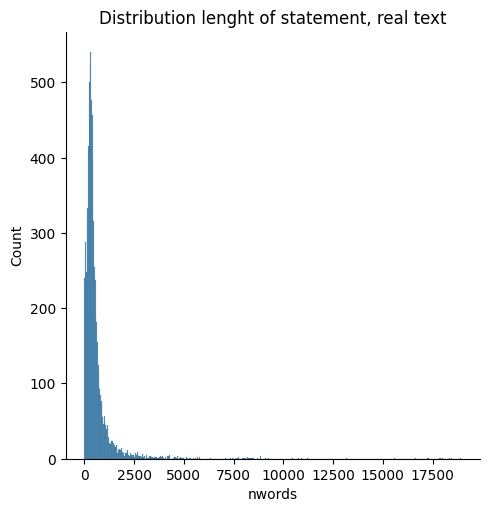

In [247]:
sns.displot(x='nwords', data=real);

plt.title("Distribution lenght of statement, real text");

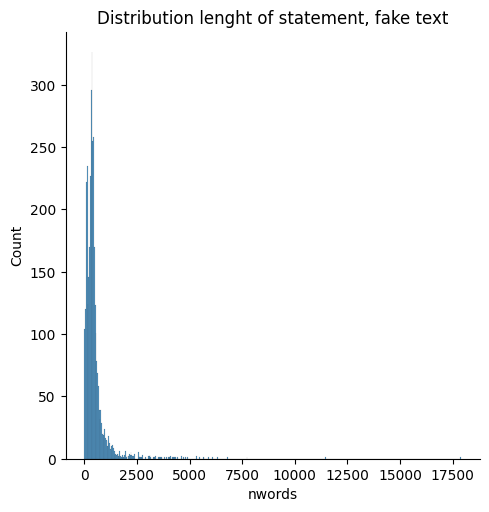

In [248]:
sns.displot(x='nwords', data=fake);

plt.title("Distribution lenght of statement, fake text");

In [249]:
real.describe()

,fake,text_len,title_len,nwords
count,7657.0,7657.000000,7657.000000,7657.000000
mean,0.0,3440.715032,68.343607,610.324670
std,0.0,6217.620199,19.989224,1100.868642
min,0.0,21.000000,4.000000,5.000000
25%,0.0,1342.000000,56.000000,236.000000
50%,0.0,2100.000000,67.000000,375.000000
75%,0.0,3403.000000,81.000000,606.000000
max,0.0,100000.000000,175.000000,18937.000000


In [250]:
fake.describe()

,fake,text_len,title_len,nwords
count,3576.0,3576.000000,3576.000000,3576.000000
mean,1.0,2707.906040,70.092841,483.075503
std,0.0,3770.255239,20.954904,670.940150
min,1.0,27.000000,5.000000,6.000000
25%,1.0,1236.500000,57.000000,219.000000
50%,1.0,1986.000000,69.000000,362.500000
75%,1.0,2830.250000,83.000000,508.000000
max,1.0,100000.000000,200.000000,17903.000000


In [251]:
real.nwords.mode()

0    329
Name: nwords, dtype: int64

In [252]:
fake.nwords.mode()

0    134
Name: nwords, dtype: int64